# Set Up & Loading yt Data, Adding Trident Fields

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import yt
import pandas as pd
import trident as tr

In [2]:
np.set_printoptions(precision=20)

In [3]:
ds = yt.load( '/Users/chellhnl/FIRE_analysis/m12i_res7100/output/snapdir_600' )

yt : [INFO     ] 2022-11-22 01:42:17,364 Calculating time from 1.000e+00 to be 4.355e+17 seconds
yt : [INFO     ] 2022-11-22 01:42:17,365 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2022-11-22 01:42:17,419 Parameters: current_time              = 4.3545571088051405e+17 s
yt : [INFO     ] 2022-11-22 01:42:17,420 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2022-11-22 01:42:17,421 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-11-22 01:42:17,423 Parameters: domain_right_edge         = [60000. 60000. 60000.]
yt : [INFO     ] 2022-11-22 01:42:17,423 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2022-11-22 01:42:17,423 Parameters: current_redshift          = 0.0
yt : [INFO     ] 2022-11-22 01:42:17,424 Parameters: omega_lambda              = 0.728
yt : [INFO     ] 2022-11-22 01:42:17,424 Parameters: omega_matter              = 0.272
yt : [INFO     ] 2022-11-22 01:42:17,424 Parameters: omega_radiation           = 0.

In [4]:
data = ds.all_data()

yt : [INFO     ] 2022-11-22 01:42:17,534 Allocating for 1.471e+08 particles
Loading particle index: 100%|██████████████| 272/272 [00:00<00:00, 42538.90it/s]


In [5]:
tr.add_ion_fields(ds, ions=['O VI','C IV', 'Si II', 'Mg II','Na I'])

/Users/chellhnl/opt/anaconda3/envs/skymap/lib/python3.10/site-packages/unyt/array.py:1758: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


## Getting the Center of Galaxy Using Halo Data

In [6]:
halo_catalog_fp = '/Users/chellhnl/FIRE_analysis/m12i_res7100/halo/rockstar_dm/catalog_hdf5/halo_600.hdf5'

import h5py
f = h5py.File( halo_catalog_fp, 'r' ) #f is a dictionary, so you can do f.keys()
index = f['mass'][...].argmax() 

#... means indexing all of it, because HDF5 doesn't show you everything unless you ask for it
#.argmax() gets the index of maximum.
#maximum mass is center because host galaxy is the one in the center so it should have the most mass.

center_ckpc = f['position'][...][index]
#the actual code to bring it to modern day, getting physical distance, is below. 
#not used because error but f[redshift] is 0 so it's basically center_ckpc

center = center_ckpc / ( 1. + f['snapshot:redshift'][...] )

kpc = ds.quan( 1, 'kpc' )
center_kpc=center*kpc

## Making the Sun the Origin Using Vector Math

In [7]:
gas_coordinates = (data[('PartType0', 'Coordinates')]).in_units("kpc")

### First need to filter out really far star particles that are not in the galaxy

In [8]:
#apply distance formula from each star coordinate to the center. if <150 kpc, it is within a good range.
distance_to_center=np.sqrt( (gas_coordinates[:,0]-center_kpc[0] )**2 + (gas_coordinates[:,1]-center_kpc[1])**2 +(gas_coordinates[:,2]-center_kpc[2])**2 )

within_range = distance_to_center < (150.*kpc)
galaxy_gas = gas_coordinates[within_range]


### Then do vector math, applying refined list of particle coordinates

In [9]:
# Get dataset units
kpc = ds.quan( 1, 'kpc' )

# Calculate the angular momentum (extracting a sphere around the galaxy first for it).
# `center` is the center of the galaxy in kpc.
sp = ds.sphere( center_kpc , (10, "kpc")) #10 is radius
jtot = sp.quantities.angular_momentum_vector( particle_type='PartType0' ).to( 'kpc * km / s' ).value

# Unit vectors for a frame w/ zhat aligned with the total angular momentum
zhat = jtot / np.linalg.norm( jtot ) #basically getting the unit vector by dividing jtot vector by its magnitude

#cross product of zhat and some vector to get a vector that's perpendicular to zhat (along galaxy disk):
xhat = np.cross( [ 1, 0, 0 ], zhat )
xhat /= np.linalg.norm( xhat )

# Sun position in simulation coordinates -> 8 kpc from center at an arbitrary angle
sun_position = center_kpc + (8. * xhat *kpc)

# Unit vectors for on-sky coordinate system.
# xskyhat points from the sun to the center of the galaxy.
# zskyhat points parallel to the axis of total angular momentum.
# yskyhat (should) point to the left on a sky map.
xskyhat = -xhat
zskyhat = zhat
yskyhat = np.cross( zskyhat, xskyhat )

# Given a series of positions (the undefined vector)
# shift them over, i.e. make a new frame centered on the sun.
positions_sun = galaxy_gas - sun_position

# And now rotate them to the sky frame
positions_sky = np.array([
    np.dot( positions_sun, xskyhat ), # Check the axis argument, this may not be right
    np.dot( positions_sun, yskyhat ),
    np.dot( positions_sun, zskyhat ),
    ]).transpose()

## Now Convert these Cartesian Coordinates to Spherical Coordinates

In [28]:
radius_coords = np.sqrt( positions_sky[:,0]**2 + positions_sky[:,1]**2 + positions_sky[:,2]**2 )
theta_coords = np.arccos( positions_sky[:,2] / radius_coords )
phi_coords= np.arctan2( positions_sky[:,1], positions_sky[:,0] )
phi_coords = np.mod(phi_coords+2*np.pi, 2*np.pi)

print(radius_coords)
print(theta_coords)
print(phi_coords)

[11.394112317423044 11.207914807742812 11.143848969944827 ...
 68.29674344098024  66.9200837196326   66.46288460116897 ]
[1.537462556416032  1.541884623145707  1.5273028481628916 ...
 0.7822049673200279 0.7879771744587025 0.8049266360498379]
[5.4376046884219456  5.443545972286514   5.442200097808355   ...
 0.37535254794228745 0.37633369227997715 0.36086678035451847]


# Healpy Skymaps

In [24]:
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
def trions_frac(ion):
    """
    This function returns an array of trident ion fractions, based on the added trident ion fields.
    Use the following arguments:
    'Mg_p1_ion_fraction' for Mg I Metallicity
    'O_p5_ion_fraction' for O V Metallicity
    'C_p3_ion_fraction' for C III Metallicity
    'Si_p1_ion_fraction' for Si I Metallicity
    'Na_p0_ion_fraction' for Na I Metallicity
    
    """

    return data[('gas', ion)][within_range]

def chem_in_galaxy(species):
    """
    These are the metallicities from the dataset that yt loaded (no trident ions).
    This function returns an array of the metallicity of interest.
    
    "Metallicity_00" = H metallicity
    "Metallicity_01" = He metallicity
    "Metallicity_02" = C metallicity
    "Metallicity_03" = N metallicity
    "Metallicity_04" = O metallicity
    "Metallicity_05" = Ne metallicity
    "Metallicity_06" = Mg metallicity
    "Metallicity_07" = Si metallicity
    "Metallicity_08" = S metallicity
    "Metallicity_09" = Ca metallicity
    "Metallicity_10" = Fe metallicity
    
    """

    return data[('PartType0', species)][within_range]

def all_data_table(nside):
    """
    Making a function that creates a dataframe of dataset quantities of interest, 
    which will be manipulated for implementation of Healpy. The purpose of this is
    for the quantities to stay in the correct order as healpy assigns index numbers
    to each data point (which is later used to make the sky map).
    
    """
    each_mass=data[('PartType0', 'Masses')].in_units("Msun")[within_range]
    each_temp=data[('PartType0', 'Temperature')][within_range]
    pixel_indices = hp.ang2pix(nside, theta_coords, phi_coords)

    dict1={'Radius': radius_coords,
           'Theta': theta_coords,
           'Phi':phi_coords, 
           'Pixel Index': pixel_indices , 
           'Mass (Msun)':each_mass,
           'Temp (K)':each_temp,
           'C III Metallicity': trions_frac('C_p3_ion_fraction'),
           'O V Metallicity': trions_frac('O_p5_ion_fraction'),
           'Mg I Metallicity': trions_frac('Mg_p1_ion_fraction'),
           'Si I Metallicity': trions_frac('Si_p1_ion_fraction'),
           'Na I Metallicity': trions_frac('Na_p0_ion_fraction'),
           'H Metallicity': chem_in_galaxy('Metallicity_00'),
           'He Metallicity': chem_in_galaxy('Metallicity_01'),
           'C Metallicity': chem_in_galaxy('Metallicity_02'),
           'N Metallicity': chem_in_galaxy('Metallicity_03'),
           'O Metallicity': chem_in_galaxy('Metallicity_04'),
           'Ne Metallicity': chem_in_galaxy('Metallicity_05'),
           'Mg Metallicity': chem_in_galaxy('Metallicity_06'),
           'Si Metallicity': chem_in_galaxy('Metallicity_07'),
           'S Metallicity': chem_in_galaxy('Metallicity_08'),
           'Ca Metallicity': chem_in_galaxy('Metallicity_09'),
           'Fe Metallicity': chem_in_galaxy('Metallicity_10'),
          }

    all_data_table = pd.DataFrame(dict1)

    #since the index numbers are not in order, this next step sorts the table by pixel index:
    all_data_table_pixelsort = all_data_table.sort_values(by=['Pixel Index'])
    return all_data_table_pixelsort

def hpmollweide_plot(nside, title, pixel, mapvals, cmap=None, min=None, max=None):
    #function that just creates a Healpy mollweide plot. the higher the nside, the more pixels the map has.
    import matplotlib.colors as mplc
    hp_map = np.zeros(hp.nside2npix(nside))
    hp_map[pixel] = mapvals
    min_nonzero = hp_map[hp_map>0.].min() #changing the minimum so that it's not log(0) (error)
    hp_map[hp_map<=0.] = min_nonzero
    norm = mplc.LogNorm()
    return hp.mollview(hp_map, norm=norm, title=title, cmap=cmap, min=min, max=max)

### The Surface Density Map $ (\frac {M_{\odot}}{rad^{2}}) $ 

In [30]:
def hpmap_surfacedensity(nside):
    #create a dataframe that's the sum of each grouped index for mass divided by pixel area
    
    pxl_area = hp.nside2resol(nside) #surface area of pixel in radians^2
    just_masses = all_data_table(nside).filter(['Pixel Index','Mass (Msun)'], axis=1)
    massweighted_data = (just_masses.groupby(['Pixel Index']).sum()/pxl_area).rename(columns={"Mass (Msun)": 'Msun/rad^2'}).reset_index()
    
    #new data to use for healpy mollweide function
    surfacedensities = massweighted_data["Msun/rad^2"].to_numpy()
    pixel_indices_refined = massweighted_data["Pixel Index"].to_numpy()
    
    #for the map function
    mapvals = surfacedensities
    pixel = pixel_indices_refined
    title = "Surface Density (Msun/rad^2)"
    
    return hpmollweide_plot(nside, title, pixel, mapvals)

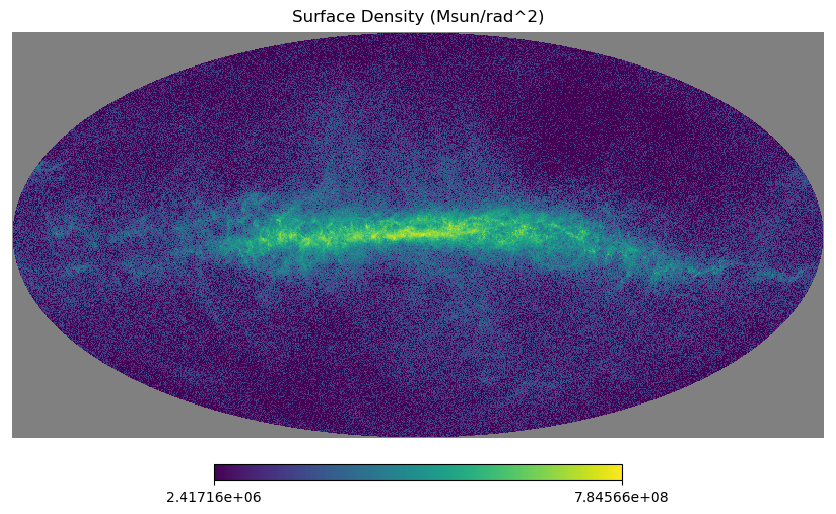

In [31]:
hpmap_surfacedensity(350)

### Metal Mass Map in Healpy ( (mass * metallicity) / pixel area)

In [32]:
#create a dataframe that's the sum of each grouped index for mass * chosen metallicity, all divided by pixel area

def hpmapmetal(nside, metal):
    # for the metal argument, use:
    # "H Metallicity"
    # "He Metallicity"
    # "C Metallicity"
    # "N Metallicity"
    # "O Metallicity"
    # "Ne Metallicity"
    # "Mg Metallicity"
    # "Si Metallicity"
    # "S Metallicity"
    # "Ca Metallicity"
    # "Fe Metallicity"
    # 'C III Metallicity'
    # 'O V Metallicity'
    # 'Mg I Metallicity'
    # 'Si I Metallicity'
    
    pxl_area = (hp.nside2resol(nside))**2
    
    metal_masses = all_data_table(nside).filter(['Pixel Index','Mass (Msun)', metal], axis=1)
    metal_masses['m * metal'] = metal_masses['Mass (Msun)'] * metal_masses[metal]
    metalmassweighted_data = (metal_masses.groupby(['Pixel Index']).sum()/pxl_area).reset_index()
    metalmassweighted_data = metalmassweighted_data.filter(['Pixel Index','m * metal'], axis=1).rename(columns={"m * metal": 'Msun/rad^2'})
    
    metallicity_vals = metalmassweighted_data["Msun/rad^2"].to_numpy()
    new_hppixels = metalmassweighted_data["Pixel Index"].to_numpy()
    print("The maximum mass of the element per pixel area is: ", metallicity_vals.max(), "Msun / rad^2")
    print("The minimum mass of the element per pixel area is: ", metallicity_vals.min(), "Msun / rad^2")
    
    #for the map function:
    title = metal+ " "+ r'$\frac{M_{\odot}}{rad^2}$'
    mapvals=metallicity_vals
    pixel=new_hppixels
    
    if metal=='C III Metallicity'\
        or metal=='O V Metallicity'\
        or metal=='Mg I Metallicity'\
        or metal=='Si I Metallicity':
        return hpmollweide_plot(nside, title, pixel, mapvals, min=10e-4, max=1e10)
    elif metal=='Na I Metallicity':
        return hpmollweide_plot(nside, title, pixel, mapvals, cmap='cubehelix_r', min=10e-4, max=10e11)
    else:
        return hpmollweide_plot(nside, title, pixel, mapvals, min=10e-3, max=10e7)

The maximum mass of the element per pixel area is:  128611081345.38023 Msun / rad^2
The minimum mass of the element per pixel area is:  0.0 Msun / rad^2


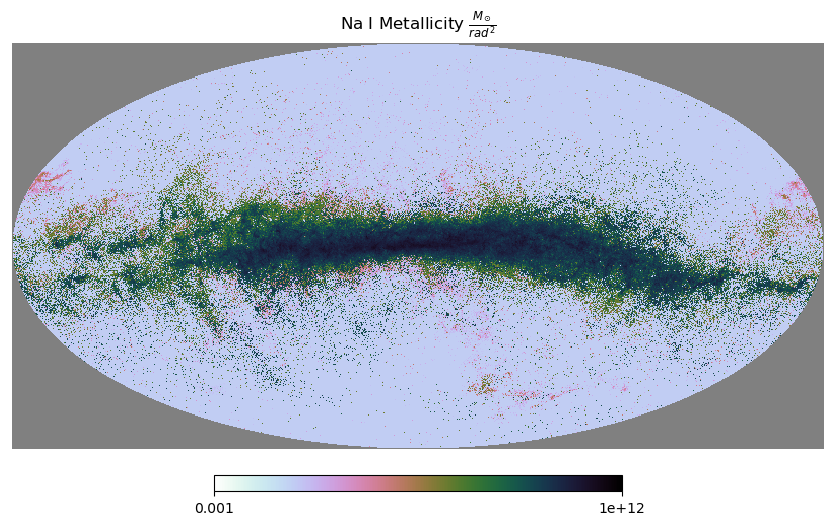

In [33]:
hpmapmetal(350, 'Na I Metallicity')

The maximum mass of the element per pixel area is:  1585644949.3622894 Msun / rad^2
The minimum mass of the element per pixel area is:  0.0 Msun / rad^2


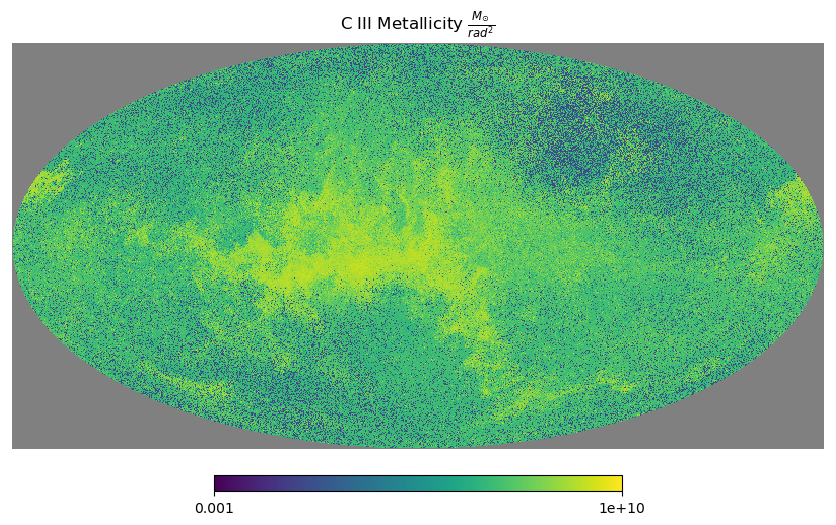

In [34]:
hpmapmetal(350, 'C III Metallicity')

The maximum mass of the element per pixel area is:  245842113769.36795 Msun / rad^2
The minimum mass of the element per pixel area is:  0.0 Msun / rad^2


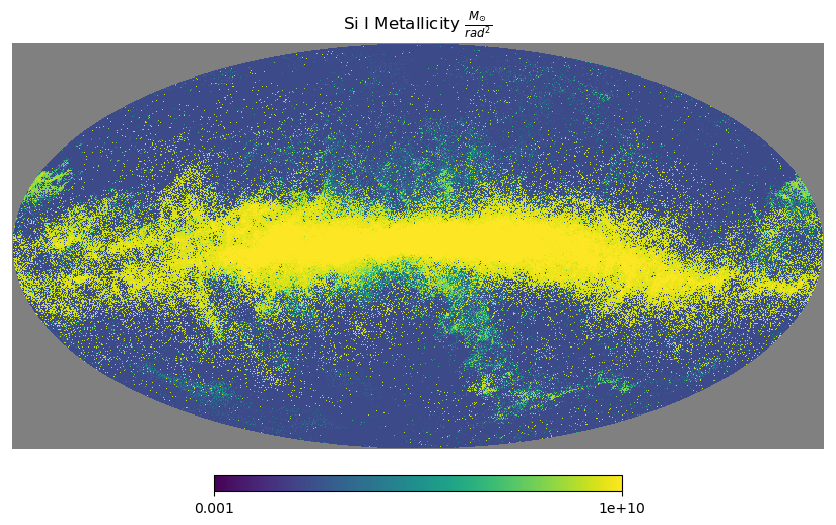

In [35]:
hpmapmetal(350, 'Si I Metallicity')

The maximum mass of the element per pixel area is:  115909931425.30971 Msun / rad^2
The minimum mass of the element per pixel area is:  0.0 Msun / rad^2


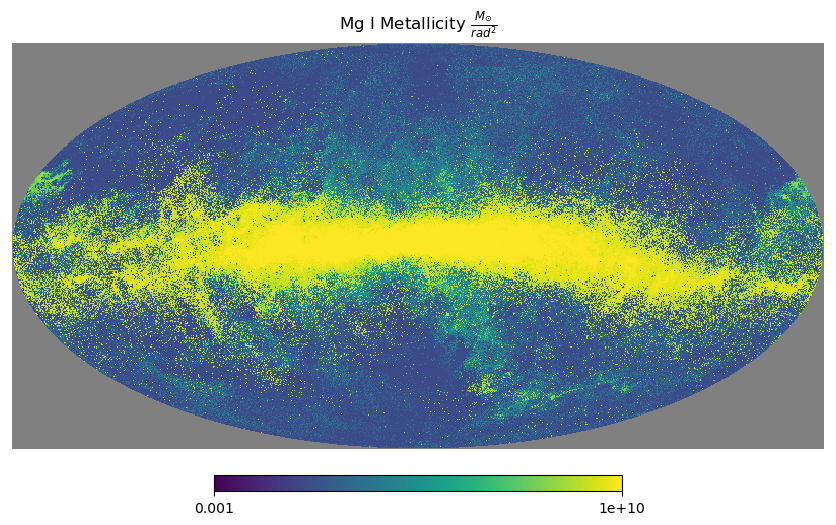

In [36]:
hpmapmetal(350, 'Mg I Metallicity')

### Healpy Average Temperature Map

In [37]:
def hpmaptemp(nside):
    pxl_area_temp = hp.nside2resol(nside)
    
    temp_mass_table = all_data_table(350).filter(['Pixel Index','Mass (Msun)', 'Temp (K)'], axis=1)
    temp_mass_table['T * m'] = (temp_mass_table['Mass (Msun)'] * temp_mass_table['Temp (K)'])
    avgtemp_table = (temp_mass_table.groupby(['Pixel Index']).sum()).reset_index()
    avgtemp_table['(T * m)/pixel area'] = avgtemp_table['T * m']/hp.nside2resol(350)
    avgtemp_table['total m/pixel area'] = avgtemp_table['Mass (Msun)']/hp.nside2resol(350)
    avgtemp_table['Final Temp (K)'] = avgtemp_table['(T * m)/pixel area'] / avgtemp_table['total m/pixel area']
    # to not confuse with the other columns, which are not used:
    avgtemp_table = avgtemp_table.filter(['Pixel Index','Final Temp (K)'], axis=1)

    avgtemp_vals = avgtemp_table['Final Temp (K)'].to_numpy()
    avgtemp_hppixels = avgtemp_table['Pixel Index'].to_numpy()
    print("The maximum average temperature is: ", avgtemp_vals.max(), "K")
    print("The minimum average temperature is: ", avgtemp_vals.min(), "K")
    
    #for the map function:
    title="Average Temperature (K)"
    mapvals=avgtemp_vals
    pixel=avgtemp_hppixels
    
    return hpmollweide_plot(nside, title, pixel, mapvals)

The maximum average temperature is:  14150519.603677854 K
The minimum average temperature is:  10.006868651452423 K


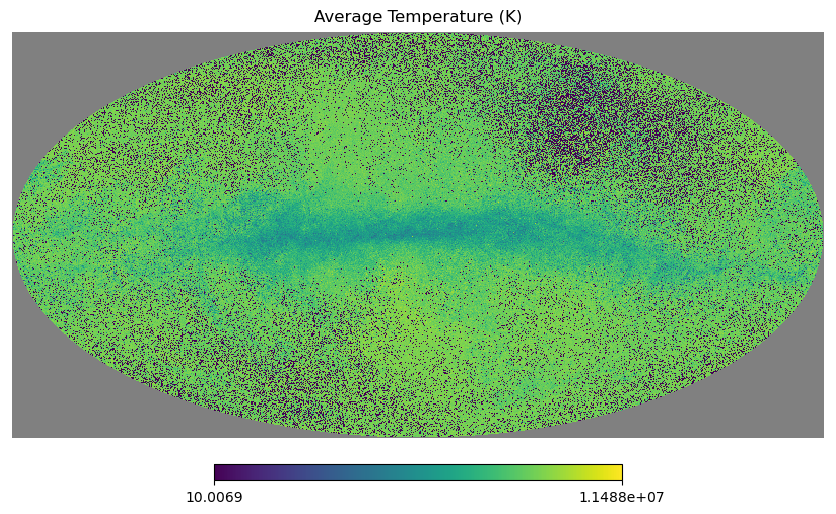

In [38]:
hpmaptemp(350)

# Cartopy Maps

In [ ]:
import cartopy.crs as ccrs

In [ ]:
def ion_fracs_times_mass(ion):
    each_mass=data[('PartType0', 'Masses')].in_units("Msun")[within_range]
    if ion=='C_p3_ion_fraction'\
        or ion=='O_p5_ion_fraction'\
        or ion=='Mg_p1_ion_fraction'\
        or ion=='Si_p1_ion_fraction'\
        or ion=='Na_p0_ion_fraction':
            return trions_frac(ion)*each_mass
    else:
        return chem_in_galaxy(ion)*each_mass

In [ ]:
def weights_array_cartopy(quantity):
    """
    The quantity argument is the keys of the dictionary.
    
    """
    
    each_mass=data[('PartType0', 'Masses')].in_units("Msun")[within_range]
    each_temp=data[('PartType0', 'Temperature')][within_range]

    dict2 = {'Mass (Msun)':each_mass,
           'Temp (K)': each_temp,
           'C III Metallicity': ion_fracs_times_mass('C_p3_ion_fraction'),
           'O V Metallicity': ion_fracs_times_mass('O_p5_ion_fraction'),
           'Mg I Metallicity': ion_fracs_times_mass('Mg_p1_ion_fraction'),
           'Si I Metallicity': ion_fracs_times_mass('Si_p1_ion_fraction'),
           'Na I Metallicity': ion_fracs_times_mass('Na_p0_ion_fraction'),
           'H Metallicity': ion_fracs_times_mass('Metallicity_00'),
           'He Metallicity': ion_fracs_times_mass('Metallicity_01'),
           'C Metallicity': ion_fracs_times_mass('Metallicity_02'),
           'N Metallicity': ion_fracs_times_mass('Metallicity_03'),
           'O Metallicity': ion_fracs_times_mass('Metallicity_04'),
           'Ne Metallicity': ion_fracs_times_mass('Metallicity_05'),
           'Mg Metallicity': ion_fracs_times_mass('Metallicity_06'),
           'Si Metallicity': ion_fracs_times_mass('Metallicity_07'),
           'S Metallicity': ion_fracs_times_mass('Metallicity_08'),
           'Ca Metallicity': ion_fracs_times_mass('Metallicity_09'),
           'Fe Metallicity': ion_fracs_times_mass('Metallicity_10'),
          }

    all_data_table2 = pd.DataFrame(dict2)
    quantity_array = all_data_table2[quantity].to_numpy()
    
    return quantity_array

In [ ]:
proj = ccrs.Mollweide()
img_proj = ccrs.PlateCarree()

In [ ]:
def plot_projected_hist(
    ax,
    phi=phi_coords,
    theta=theta_coords,
    weights=None,
    color_axis=None,
    cmap=matplotlib.cm.cubehelix_r,
    vmin=None,
    vmax=None,
    norm=matplotlib.colors.LogNorm(),
    n_bins=256,
):
    
    ra_edges = np.linspace( 0, 2*np.pi, n_bins )
    cosdec_edges = np.linspace( -1, 1, n_bins )

    # Make the numpy histogram: gives 2d array, x array, and y array
    hist2d, ra_edges, da_edges = np.histogram2d(
        phi,
        np.cos( theta ),
        bins = [ ra_edges, cosdec_edges ],
        weights = weights,
    )
   
    hist_norm = ( ra_edges[1] - ra_edges[0] ) * ( cosdec_edges[1] - cosdec_edges[0] )
    hist2d /= hist_norm

    # Get centers in degrees
    ra_centers = 360 - 0.5 * ( ra_edges[1:] + ra_edges[:-1] ) * 180. / np.pi
    dec_edges =  np.pi / 2. - np.arccos( cosdec_edges )
    dec_edges *= 180. / np.pi
    dec_centers = 0.5 * ( dec_edges[1:] + dec_edges[:-1] )
    

    img = ax.pcolormesh(
        ra_centers,
        dec_centers,
        hist2d.transpose(),
        transform = img_proj,
        cmap = cmap,
        shading = 'nearest',
        vmin = vmin,
        vmax = vmax,
        norm = norm,
    )
    plt.colorbar(img, location='bottom', orientation='horizontal', label='Msun/pixel area')
    plt.title("Cartopy Na I Metallicity")
    
    return hist2d, img

In [ ]:
# SET UP FIGURE BELOW:
cartopy_map = plt.figure(figsize=(10,10))
ax1 = plt.axes(projection=proj)

#histogram (2d array, and the image):
cartopy_visual=plot_projected_hist(
    ax=ax1,
    phi=phi_coords,
    theta=theta_coords,
    weights=weights_array_cartopy('Na I Metallicity'),
    n_bins=750 
)

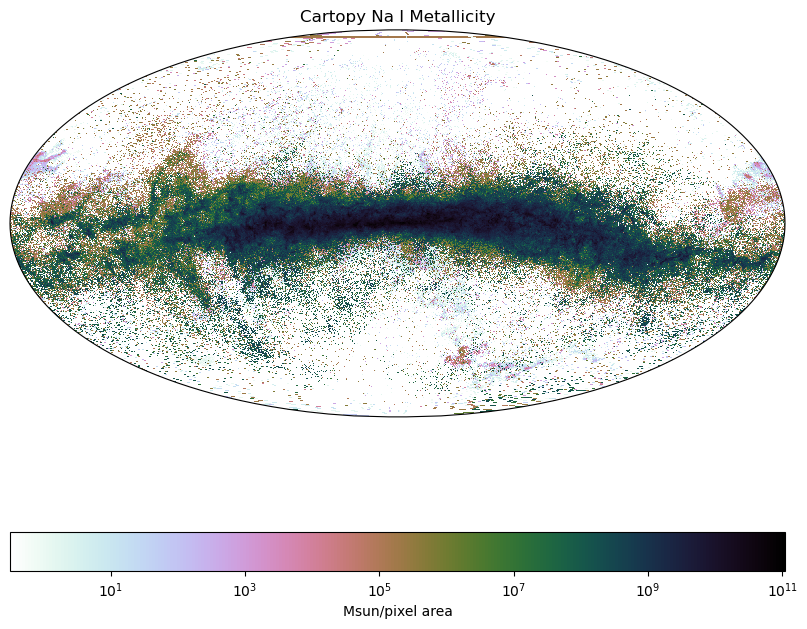